In [ ]:
import os
os.environ["WANDB_ENTITY"] = "mlclass"

In [1]:
import keras
import wandb
from wandb.keras import WandbCallback
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
import groceries
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(x_train, y_train_raw), (x_test, y_test_raw), class_names = groceries.load_data()

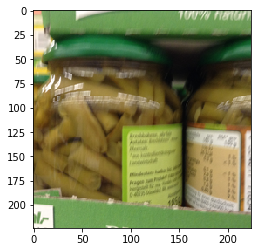

In [3]:
# take a look at the kinds of images we're dealing with
plt.imshow(x_train[100].astype(int))

In [4]:
# Print out the classes we need to target
class_names

['BEANS',
 'CAKE',
 'CANDY',
 'CEREAL',
 'CHIPS',
 'CHOCOLATE',
 'COFFEE',
 'CORN',
 'FISH',
 'FLOUR',
 'HONEY',
 'JAM',
 'JUICE',
 'MILK',
 'NUTS',
 'OIL',
 'PASTA',
 'RICE',
 'SODA',
 'SPICES',
 'SUGAR',
 'TEA',
 'TOMATO_SAUCE',
 'VINEGAR',
 'WATER']

(array([639., 439., 672., 199., 406., 602., 295., 504., 381., 560.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

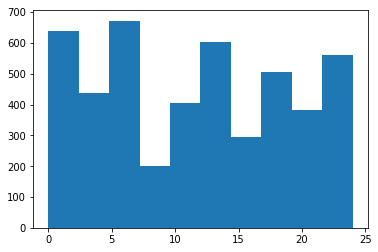

In [5]:
# check how balanced our class distribution is
plt.hist(y_train_raw)

In [6]:
# One hot encode ouput
y_train = keras.utils.to_categorical(y_train_raw)
y_test = keras.utils.to_categorical(y_test_raw)

In [7]:
# We build an extremely simple perceptron to try to fit our data

x_train_normalized = x_train / 255.
x_test_normalized = x_test / 255.

very_simple_model=Sequential()
very_simple_model.add(Flatten())
very_simple_model.add(Dense(25, activation="sigmoid"))
very_simple_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

wandb.init(project="transfer learn")
very_simple_model.fit(x_train_normalized, y_train, epochs=10, validation_data=(x_test_normalized, y_test), callbacks=[WandbCallback()])

W&B Run: https://app.wandb.ai/mlclass/transfer learn/runs/qf6yjgj0
Call `%%wandb` in the cell containing your training loop to display live results.
Train on 4697 samples, validate on 250 samples
Epoch 1/10
4697/4697 [==============================] - 6s 1ms/step - loss: 8.6940 - acc: 0.0319 - val_loss: 9.5742 - val_acc: 0.0400
Epoch 2/10
4697/4697 [==============================] - 5s 1ms/step - loss: 8.6992 - acc: 0.0321 - val_loss: 9.5742 - val_acc: 0.0400
Epoch 3/10
4697/4697 [==============================] - 5s 1ms/step - loss: 8.6992 - acc: 0.0321 - val_loss: 9.5742 - val_acc: 0.0400
Epoch 4/10
4697/4697 [==============================] - 5s 1ms/step - loss: 8.6992 - acc: 0.0321 - val_loss: 9.5742 - val_acc: 0.0400
Epoch 5/10
4697/4697 [==============================] - 5s 1ms/step - loss: 8.6992 - acc: 0.0321 - val_loss: 9.5742 - val_acc: 0.0400
Epoch 6/10
4697/4697 [==============================] - 5s 1ms/step - loss: 8.6992 - acc: 0.0321 - val_loss: 9.5742 - val_acc: 0.0400


In [8]:
# Load ResNet50 Trained on imagenet
resnet_model = ResNet50(weights="imagenet")

In [9]:
resnet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
from keras.preprocessing import image
import numpy as np
img = image.load_img('elephant.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = resnet_model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])


Predicted: [('n01871265', 'tusker', 0.48542652), ('n02504013', 'Indian_elephant', 0.3432938), ('n02504458', 'African_elephant', 0.17125048)]


In [11]:
# We should preprocess the images the same way resnet images were preprocessed
x_train_preprocessed = preprocess_input(x_train)
x_test_preprocessed = preprocess_input(x_test)

In [12]:
# Build a new model that is ResNet50 minus the very last layer
last_layer = resnet_model.get_layer("avg_pool")

resnet_layers = keras.Model(inputs=resnet_model.inputs, outputs=last_layer.output)
resnet_layers.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [13]:
# We use our resnet to "predict" but because we have removed the top layer, 
# this outputs the activations of the second to last layer on our dataset

x_train_features = resnet_layers.predict(x_train_preprocessed)

In [14]:
x_test_features = resnet_layers.predict(x_test_preprocessed)

In [15]:
feature_model=Sequential()
feature_model.add(Dense(25, activation="sigmoid"))
feature_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
wandb.init(project="transfer learn")
feature_model.fit(x_train_features, y_train, epochs=50, validation_data=(x_test_features, y_test), callbacks=[WandbCallback()])

W&B Run: https://app.wandb.ai/mlclass/transfer learn/runs/fhj30zry
Call `%%wandb` in the cell containing your training loop to display live results.
Train on 4697 samples, validate on 250 samples
Epoch 1/50
4697/4697 [==============================] - 1s 315us/step - loss: 1.6686 - acc: 0.4880 - val_loss: 1.2663 - val_acc: 0.5880
Epoch 2/50
4697/4697 [==============================] - 1s 125us/step - loss: 0.6745 - acc: 0.8086 - val_loss: 1.0515 - val_acc: 0.6600
Epoch 3/50
4697/4697 [==============================] - 1s 127us/step - loss: 0.4548 - acc: 0.8844 - val_loss: 0.9101 - val_acc: 0.7080
Epoch 4/50
4697/4697 [==============================] - 1s 127us/step - loss: 0.3314 - acc: 0.9263 - val_loss: 0.8746 - val_acc: 0.7120
Epoch 5/50
4697/4697 [==============================] - 1s 118us/step - loss: 0.2507 - acc: 0.9500 - val_loss: 0.8200 - val_acc: 0.7600
Epoch 6/50
4697/4697 [==============================] - 1s 119us/step - loss: 0.1928 - acc: 0.9719 - val_loss: 0.8054 - val_

In [17]:
# We can directly stich the models together

new_model=Sequential()
new_model.add(resnet_layers)
new_model.add(Dense(25, activation="sigmoid"))

new_model.layers[0].trainable=False

new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 25)                51225     
Total params: 23,638,937
Trainable params: 51,225
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
wandb.init(project="transfer learn")
new_model.fit(x_train_preprocessed, y_train, epochs=50, validation_data=(x_test_preprocessed, y_test), callbacks=[WandbCallback()])

W&B Run: https://app.wandb.ai/mlclass/transfer learn/runs/xerthmqh
Call `%%wandb` in the cell containing your training loop to display live results.
Train on 4697 samples, validate on 250 samples
Epoch 1/50
4697/4697 [==============================] - 43s 9ms/step - loss: 1.7996 - acc: 0.4826 - val_loss: 2.0460 - val_acc: 0.4000
Epoch 2/50
4697/4697 [==============================] - 41s 9ms/step - loss: 0.8081 - acc: 0.7739 - val_loss: 2.0796 - val_acc: 0.4360
Epoch 3/50
4697/4697 [==============================] - 41s 9ms/step - loss: 0.5515 - acc: 0.8567 - val_loss: 1.9751 - val_acc: 0.4120
Epoch 4/50
4697/4697 [==============================] - 41s 9ms/step - loss: 0.4258 - acc: 0.8948 - val_loss: 1.9526 - val_acc: 0.4560
Epoch 5/50
4672/4697 [============================>.] - ETA: 0s - loss: 0.3375 - acc: 0.9195

KeyboardInterrupt: 

In [ ]:
# We can allow some of the resnet layers to change as we train.  
# Typically you would want to lower the learning rate in conjunction with this.

new_model.layers[0].trainable = True

# We let the last 3 blocks train
for layer in new_model.layers[0].layers[:-11]:
    layer.trainable = False
for layer in new_model.layers[0].layers[-11:]:
    layer.trainable = True
    
new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

wandb.init(project="transfer learn")
new_model.fit(x_train_preprocessed, y_train, epochs=50, validation_data=(x_test_preprocessed, y_test), callbacks=[WandbCallback()])

W&B Run: https://app.wandb.ai/mlclass/transfer learn/runs/udba14n9
Call `%%wandb` in the cell containing your training loop to display live results.
Train on 4697 samples, validate on 250 samples
Epoch 1/50
4697/4697 [==============================] - 53s 11ms/step - loss: 0.5487 - acc: 0.8427 - val_loss: 1.0094 - val_acc: 0.6840
Epoch 2/50
4697/4697 [==============================] - 47s 10ms/step - loss: 0.1611 - acc: 0.9576 - val_loss: 1.1052 - val_acc: 0.7120
Epoch 3/50
4697/4697 [==============================] - 47s 10ms/step - loss: 0.0963 - acc: 0.9742 - val_loss: 1.3093 - val_acc: 0.6720
Epoch 4/50
4697/4697 [==============================] - 47s 10ms/step - loss: 0.0596 - acc: 0.9862 - val_loss: 1.0734 - val_acc: 0.7160
Epoch 5/50
4697/4697 [==============================] - 47s 10ms/step - loss: 0.0439 - acc: 0.9896 - val_loss: 1.1619 - val_acc: 0.7320
Epoch 6/50
4697/4697 [==============================] - 47s 10ms/step - loss: 0.0240 - acc: 0.9949 - val_loss: 1.0267 - val_